# Lab 3: Image Segmentation

## Python packages
**NumPy**: Used functions related to linear algebra and matrix representation. <br>
**SciPy**: Used for convolution <br>
**Matplotlib**: Used for displaying images and graphs <br>
**Functions**: Used to access files related to the course <br>
**Pillow**: Used to store colour images as three-dimensional arrays in which the last dimension represents the colour space <br>

In [1]:
import sys
import numpy as np
from scipy.signal import convolve2d, correlate2d
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from Functions import *
from gaussfft import gaussfft

## Working with images in PILLOW
**open()** is used to read images from the disk. <br>
**save()** is used to store images. <br>
**resize()** is used to change the size of the image. <br>

In [2]:
def openImage(path):
    """
    Implement file reading to load an image from disk.:
    - Input: path : image path input
    - Output: img : image as numpy array
    """
    img = Image.open(path)
    img = np.asarray(img).astype(np.float32)
    return img

## K-Means Clustering
Let X be a set of pixels and V be a set of K cluster centers in 3D (R,G,B). <br>
% Randomly initialize the K cluster centers <br>
% Compute all distances between pixels and cluster centers <br>
% Iterate L times <br>
% Assign each pixel to the cluster center for which the distance is minimum <br>
% Recompute each cluster center by taking the mean of all pixels assigned to it <br>
% Recompute all distances between pixels and cluster centers <br>

In [3]:
def initialize_cluster_centers(image, K, seed):
    np.random.seed(seed)
    h, w, d = image.shape
    flattened_data = image.reshape(h * w, d)

    # Initialize the list of chosen indices
    chosen_indices = []

    # Randomly pick the first center
    first_index = np.random.choice(h * w)
    chosen_indices.append(first_index)

    # Iteratively pick the most different pixels
    for _ in range(1, K):
        remaining_indices = [i for i in range(h * w) if i not in chosen_indices]
        distances = np.linalg.norm(flattened_data[remaining_indices] - flattened_data[chosen_indices, None, :], axis=2)
        max_distance_index = remaining_indices[np.argmax(np.min(distances, axis=0))]
        chosen_indices.append(max_distance_index)

    # Extract the initial centers
    initial_centers = flattened_data[chosen_indices]
    return initial_centers

def kmeans_segm(image, K, L, seed):
    """
    Implement k-means clustering:
    - Input: image : image input
             K : number of cluster centres
             L : number of iterations
             seed : to initialize random generator
    - Output: segmentation : segmented image with a colour index per pixel
              centers : final cluster centres in 3D colour space
    """
    # This is used to flatten the image
    h, w, d = image.shape
    Ivec = np.reshape(image, (h * w, d))

    # Apply k-means clustering algorithm
    # Initialize cluster centers randomly
    centers = initialize_cluster_centers(image, K, seed)

    # Initialize nearest_clustery
    nearest_cluster = np.zeros_like(Ivec[:, 0])  

    for _ in range(L):
        # Assign pixels to the nearest cluster center by using pyhtagoras equation
        distances = distance_matrix(Ivec, centers)
        nearest_cluster = np.argmin(distances, axis=1)

        # Update cluster centers
        for k in range(K):
            if np.any(nearest_cluster == k):
                centers[k] = np.mean(Ivec[nearest_cluster == k], axis=0)
            else:
                # Reinitialize the center if the cluster is empty
                centers[k] = Ivec[np.random.choice(Ivec.shape[0])]

    segmentation = np.reshape(nearest_cluster, (h, w))
    return segmentation, centers

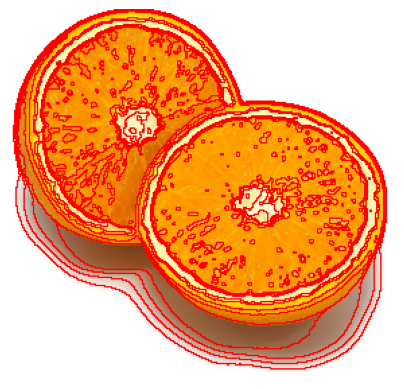

In [15]:
def kmeans_example():
    K = 10              # number of clusters used
    L = 50              # number of iterations
    seed = 14           # seed used for random initialization
    scale_factor = 0.5  # image downscale factor
    image_sigma = 1.0   # image preblurring scale
    
    img = Image.open('Images-jpg/orange.jpg')
    img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
    
    h = ImageFilter.GaussianBlur(image_sigma)
    I = np.asarray(img.filter(ImageFilter.GaussianBlur(image_sigma))).astype(np.float32)
    
    segm, centers = kmeans_segm(I, K, L, seed)
    Inew = mean_segments(img, segm)
    if True:
        Inew = overlay_bounds(img, segm)

    img = Image.fromarray(Inew.astype(np.ubyte))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img.save('C:/Users/karen/git/Computer-Vision-course/Labs/Lab 2/Karen/result/kmeans.png')

kmeans_example()


**Question 1** <br>
How did you initialize the clustering process and why do you believe this was a good method of doing it?

**Answer** <br>
The clustering process was initialized by first randomly selecting one pixel from the image, and then iteratively selecting subsequent pixels that were the most different from all previously selected pixels. This method was chosen because it helps in spreading out the initial cluster centers across the color space of the image. By ensuring that the initial centers are as diverse as possible,the entire colour space can be explored leading to a more balanced clustering. This approach tries to prevent the initial centers from being too close to each other, which can be a limitation in random initialization, especially in images with specific color distributions.

**Question 2**<br>
How many iterations L do you typically need to reach convergence, that is the point where no additional iterations will affect the end results?

**Answer**<br>
